In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import cv2


In [25]:
df= pd.read_csv('df_eyepacs.csv')
train_df_temp= pd.read_csv('undersampled_train_val.csv')
test_df=pd.read_csv('undersampled_test.csv')

In [26]:
# Set the seed for reproducibility
np.random.seed(42)

# Set the image size for resizing
img_size = (128, 128)

# Define the batch size
batch_size = 32

# Define the number of epochs
epochs = 50

In [27]:
def image_preprocessing(img):
    # Read the image
#   img = mpimg.imread(img_path)
    img = img.astype(np.uint8)
    
    #  Extract the green channel of the image
    b, g, r = cv2.split(img)
    
    #  Apply CLAHE to intensify the green channel extracted image
    clh = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
    #r= clh.apply(r)
    g= clh.apply(g)
    #b= clh.apply(b)
   
    # Convert enhanced image to grayscale
    merged_bgr_green_fused = cv2.merge((b, g, r))
    img_bw = cv2.cvtColor(merged_bgr_green_fused, cv2.COLOR_BGR2GRAY)
    
    
    # Apply Gaussian blur to remove noise
    img_blur = cv2.GaussianBlur(merged_bgr_green_fused, (5,5), 0)
    
    # Remove the isolated pixels using morphological cleaning operation.
    kernel1 = np.ones((1, 1), np.uint8)
    morph_open = cv2.morphologyEx(img_blur, cv2.MORPH_OPEN, kernel1)
    
    # Extract blood vessels using mean-C thresholding.
    #thresh = cv2.adaptiveThreshold(morph_open, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 9, 5)
    
    # Applying morph_open operation
    kernel2 = np.ones((2, 2), np.uint8)
    morph_open2 = cv2.morphologyEx(morph_open, cv2.MORPH_OPEN, kernel2)
    
    # Stacking the image into 3 channels
    #stacked_img = np.stack((morph_open2,)*3, axis=-1)
    
    return morph_open2.astype("float64") #stacked_img

In [29]:
# Define the early stopping criteria
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)


from sklearn.model_selection import train_test_split

#train_df, splitdf = train_test_split(df, test_size=0.3, random_state=42)
#test_df, valid_df = train_test_split(splitdf, test_size=0.5, random_state=42)
train_df, valid_df = train_test_split(train_df_temp, test_size=0.18, random_state=42)


# Create the data generators for training and validation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,#0,35
                                   horizontal_flip = True,
                                   rotation_range = 30,  #160 #90
                                   preprocessing_function = image_preprocessing) 
                                   #width_shift_range = 0.1,
                                   #height_shift_range = 0.1,
                                   
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                       preprocessing_function = image_preprocessing)
                                        

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                              target_size=img_size,
                                              batch_size=batch_size,
                                              directory='./',
                                              x_col='path',
                                              y_col='diagnosis',# label, diagnosis
                                              class_mode="categorical")

val_generator = validation_datagen.flow_from_dataframe(dataframe=valid_df,
                                            target_size=img_size,
                                            batch_size=batch_size,
                                            directory='./',
                                            x_col='path',
                                            y_col='diagnosis',# label
                                            class_mode="categorical")


Found 3198 validated image filenames belonging to 5 classes.
Found 703 validated image filenames belonging to 5 classes.


In [30]:
# Define the model architecture
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(img_size[0], img_size[1], 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Convolutional Layer 2
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Convolutional Layer 3
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Convolutional Layer 4
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten Layer
model.add(Flatten())

# Fully Connected Layer 1
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Fully Connected Layer 2
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(5, activation='softmax'))



In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                        

In [32]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=[early_stop])

# Metrics

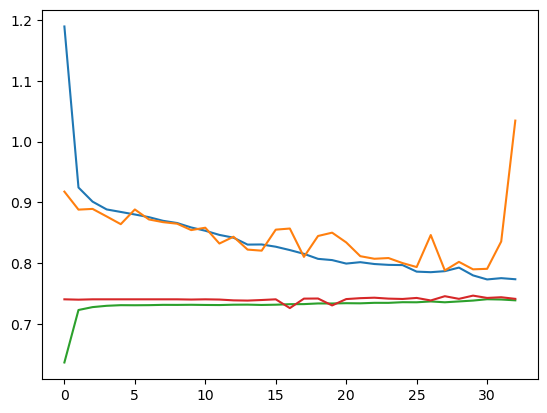

In [39]:
# Plot the training and validation loss and accuracy curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label= 'validation Accuracy')

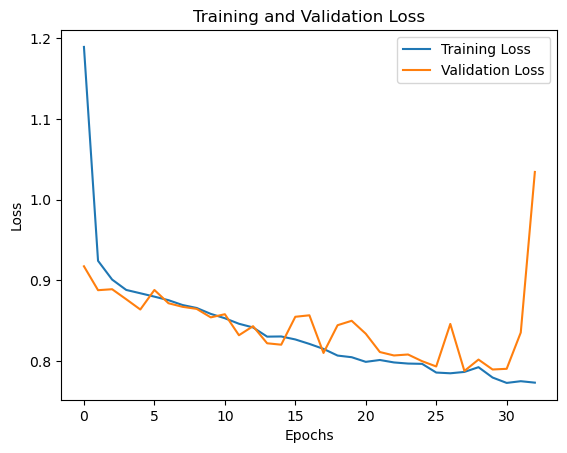

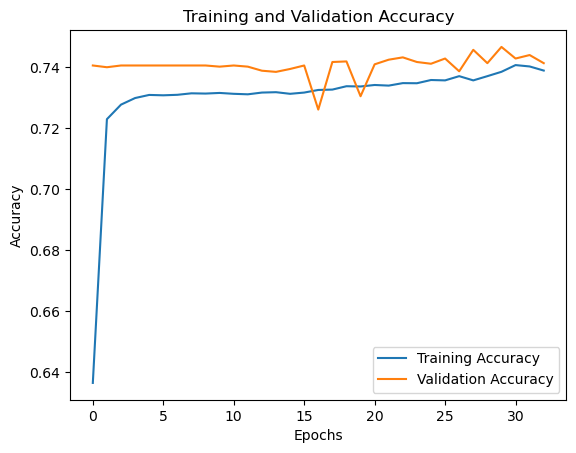

In [40]:
import matplotlib.pyplot as plt

# Train the model
#history = model.fit(train_df, train_labels, validation_data=(val_data, val_labels), epochs=10)

# Plot the loss curves for training and validation data
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves for training and validation data
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [42]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, classification_report

test_datagen = ImageDataGenerator(rescale = 1./255,
                                 preprocessing_function = image_preprocessing)
# Use the trained model to make predictions on the test dataset
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                             target_size=img_size,
                                             batch_size=batch_size,
                                                directory='./',
                                              x_col='path',
                                              y_col='label',
                                             class_mode='categorical')
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels for the test dataset
y_true = test_generator.classes


Found 5266 validated image filenames belonging to 5 classes.
165/165 [==============================] - 214s 1s/step


In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print(cm)

# Generate the classification report
class_names = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

In [44]:
scores = model.evaluate(test_generator)
print("Accuracy: %.2f%%" % (scores[1]*100))

165/165 [==============================] - 205s 1s/step - loss: 0.7690 - accuracy: 0.7463
Accuracy: 74.63%


In [45]:
model.save('model_CNN.h5')

# splitting 5% fo test

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv("undersampled_images.csv")

class_counts = df['label'].value_counts()


In [18]:
min_class_counts = class_counts[class_counts < 1000]
min_class_df = df[df['label'].isin(min_class_counts.index)]
other_class_df = df[~df['label'].isin(min_class_counts.index)]


In [19]:
min_class_count = len(min_class_df)
train_val_size = int(min_class_count * 0.95)
test_size = min_class_count - train_val_size

min_class_train_val_df = min_class_df[:train_val_size]
min_class_test_df = min_class_df[-test_size:]


In [20]:
other_class_count = len(other_class_df)
train_val_size = int(other_class_count * 0.8)
test_size = other_class_count - train_val_size

other_class_train_val_df = other_class_df[:train_val_size]
other_class_test_df = other_class_df[-test_size:]


In [21]:
train_val_df = pd.concat([min_class_train_val_df, other_class_train_val_df], axis=0)
test_df = pd.concat([min_class_test_df, other_class_test_df], axis=0)


In [22]:
train_val_df = train_val_df.sample(frac=1)
test_df = test_df.sample(frac=1)


In [23]:
train_val_df.to_csv('undersampled_train_val.csv', index=False)
test_df.to_csv('undersampled_test.csv', index=False)
